In [1]:
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import RandomOverSampler
from google.colab import files
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments


In [2]:
# Xem các file đã tải lên
import pandas as pd
import io

# Đọc các file CSV vào DataFrame
real = pd.read_csv('new_real.csv')
fake = pd.read_csv('new_fake.csv')

In [3]:
real.shape

(602, 6)

In [4]:
fake.shape

(300, 6)

In [5]:
df = pd.concat([real, fake], ignore_index=True)
df.shape

(902, 6)

In [10]:
df = df.dropna(subset=['label'])

In [11]:
df['label'] = df['label'].astype(int)

In [12]:
df.columns

Index(['date', 'author_id', 'content', 'label', 'link', 'comment_list'], dtype='object')

In [13]:
df2 = df.drop(['link', 'comment_list', 'date', 'author_id'], axis=1)

In [14]:
df2.head()

,content,label
0,"Vụ xe bán tải cố vượt rào chắn, bị tàu hỏa tôn...",1
1,"TPHCM: Hơn 4.600 ca mắc sốt xuất huyết, nhiều ...",1
2,Nóng: Ngộ độc hàng loạt tại trụ sở công ty mẹ ...,1
3,Ngày mai: Giá xăng trong nước có thể giảm lần ...,1
4,Pin dự phòng của hành khách bốc cháy tại nhà ...,1


<Axes: xlabel='label'>

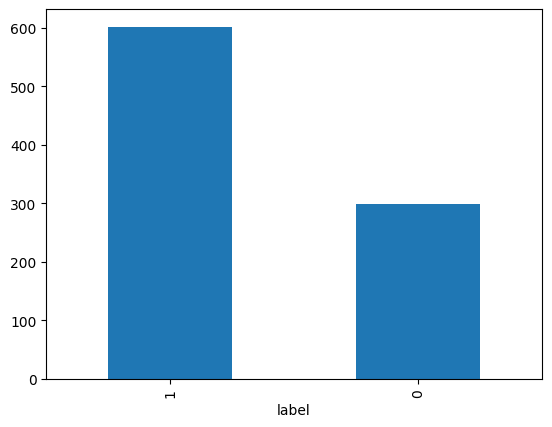

In [15]:
df2['label'].value_counts().plot.bar()

In [16]:
def clean_text(text):
    # Chuyển đổi văn bản thành chữ thường
    text = text.lower()
    # Xóa các URL
    text = re.sub(r"http\S+", "", text)
    # Xóa các ký tự không phải là chữ cái, số hoặc dấu thanh cơ bản
    text = re.sub(r"[^a-zA-Z0-9\sáàảãạăằắẳẵặâầấẩẫậèẹẻẽẽêềếểễệìíỉĩịòóỏõọôồốổỗộơờởỡợớùúủũụưừửữựứỳýỷỹỵđ]", "", text)
    # Xóa các khoảng trắng thừa
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [17]:
# Clean content
df2['content'] = df2['content'].apply(clean_text)

In [18]:
df2.head()

,content,label
0,vụ xe bán tải cố vượt rào chắn bị tàu hỏa tông...,1
1,tphcm hơn 4600 ca mắc sốt xuất huyết nhiều điể...,1
2,nóng ngộ độc hàng loạt tại trụ sở công ty mẹ t...,1
3,ngày mai giá xăng trong nước có thể giảm lần t...,1
4,pin dự phòng của hành khách bốc cháy tại nhà g...,1


<Axes: xlabel='label'>

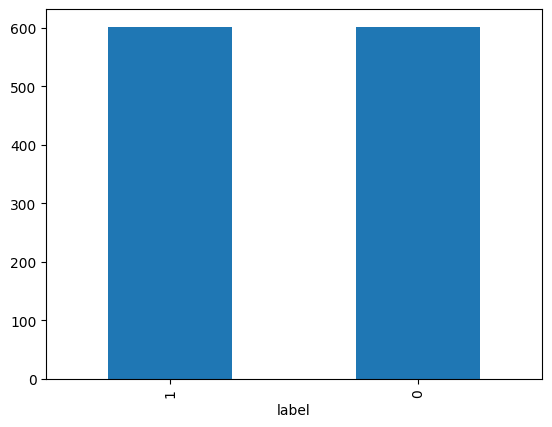

In [19]:
# Tạo bước tăng cường dữ liệu
ros = RandomOverSampler()
df2['content'] = df2['content'].astype(str)  # Đảm bảo cột nội dung là kiểu chuỗi
x_over, y_over = ros.fit_resample(df2[['content']], df2['label'])
df2 = pd.DataFrame(data=x_over, columns=['content'])
df2['label'] = y_over

# Kiểm tra phân phối nhãn
df2['label'].value_counts().plot.bar()

In [20]:
df2.shape

(1204, 2)

In [22]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")


In [23]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_texts, val_texts, train_labels, val_labels = train_test_split(df2['content'], df2['label'], test_size=0.2)

In [24]:
# Tokenize dữ liệu với padding
def tokenize_and_pad(texts, tokenizer, max_length=512):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',  # Thêm padding để tất cả các văn bản có cùng chiều dài
        max_length=max_length
    )
    return encodings

train_encodings = tokenize_and_pad(train_texts.tolist(), tokenizer, max_length=512)
val_encodings = tokenize_and_pad(val_texts.tolist(), tokenizer, max_length=512)

In [31]:
# Tokenize dữ liệu với cắt ngắn văn bản
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=256, truncation_strategy='longest_first')
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=256, truncation_strategy='longest_first')


In [32]:
# Kiểm tra dữ liệu sau khi token hóa
print(train_encodings.keys())
print(val_encodings.keys())
print(train_encodings['input_ids'][:2])  # Hiển thị một vài mẫu tokenized
print(val_encodings['input_ids'][:2])


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[[0, 452, 17, 1019, 1083, 1392, 1392, 17, 41, 7, 452, 1410, 702, 277, 13, 2162, 2380, 1392, 11, 8271, 2477, 452, 4311, 17055, 18370, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1645, 939, 53, 16, 528, 344, 53, 14427, 2710, 3

In [33]:
train_labels = np.array(train_labels).astype(int)
val_labels = np.array(val_labels).astype(int)

In [34]:
# Kiểm tra nhãn
print(set(train_labels))
print(set(val_labels))


{0, 1}
{0, 1}


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader

class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).squeeze()  # Đảm bảo nhãn có kích thước đúng
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels.tolist())
val_dataset = FakeNewsDataset(val_encodings, val_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [36]:

# Tải mô hình phân loại
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=2)

# Thiết lập các tham số huấn luyện
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Huấn luyện mô hình
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.694000
20,0.680200
30,0.683100
40,0.672900
50,0.676000
60,0.656200
70,0.654900
80,0.610500
90,0.611600
100,0.558100


TrainOutput(global_step=363, training_loss=0.42807156389409845, metrics={'train_runtime': 8488.8528, 'train_samples_per_second': 0.34, 'train_steps_per_second': 0.043, 'total_flos': 380063919467520.0, 'train_loss': 0.42807156389409845, 'epoch': 3.0})

In [38]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.4072689116001129, 'eval_runtime': 230.5139, 'eval_samples_per_second': 1.045, 'eval_steps_per_second': 0.134, 'epoch': 3.0}


In [39]:
predictions = trainer.predict(val_dataset)
print(predictions.metrics)

{'test_loss': 0.4072689116001129, 'test_runtime': 274.8498, 'test_samples_per_second': 0.877, 'test_steps_per_second': 0.113}


In [41]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/bpe.codes',
 './saved_model/added_tokens.json')

In [56]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained('./saved_model')
tokenizer = AutoTokenizer.from_pretrained('./saved_model')

inputs = tokenizer("Sập hầm thang Quảng Ninh khiến con số thiệt mạng khổng lồ", return_tensors="pt")
# Thực hiện dự đoán
with torch.no_grad():
    outputs = model(**inputs)

# Lấy logits từ kết quả dự đoán
logits = outputs.logits
print(logits)

from torch.nn.functional import softmax

probs = softmax(logits, dim=1)
print(probs)

from torch.nn.functional import softmax

# Chuyển đổi logits thành xác suất
probs = softmax(logits, dim=1)
print(probs)

# Lấy lớp dự đoán (lớp có xác suất cao nhất)
predicted_class = torch.argmax(probs, dim=1)
print(predicted_class)


tensor([[ 1.4092, -1.7504]])
tensor([[0.9593, 0.0407]])
tensor([[0.9593, 0.0407]])
tensor([0])
